### This notebook contains (1) Imputation and (2) SPI offset percentage clustering code

## 1. Imputation by KNN imputer (K=2)

In [12]:


import os

import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys

import matplotlib.pylab as pl

# set data path
dir_path = pathlib.Path().absolute()
file = './datasets/MOM4_data.csv'
data_path = os.path.join(dir_path, file)
print('MOM4 data located at:',data_path)



MOM4 data located at: /home/user/Documents/kohyoung/kybayesopt_v2/./datasets/MOM4_data.csv


In [13]:


''' Read dataset '''
# configurations for plots
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# read data
df = pd.read_csv(data_path  ,index_col=False).drop(['Unnamed: 0'], axis=1)
df.reset_index(drop=True, inplace=True)
assert df.isnull().sum().sum() == 0
df.head()



,CRD,PartType,Orient.,X,Y,SPI_VOLUME1,SPI_VOLUME2,SPI_X1,SPI_Y1,SPI_X2,SPI_Y2,SPI_L1,SPI_W1,SPI_L2,SPI_W2,SPI_L,SPI_W,PRE_X,PRE_Y,PRE_A,PRE_L,PRE_W,POST_X,POST_Y,POST_A,POST_L,POST_W,Job,Chip_L,Chip_W,SPI_R,PRE_R,POST_R,SPI_VOLUME_MEAN,SPI_VOLUME_DIFF
0,B1,R0402,90,31.26,100.11,81.7355,75.6950,-51.9,63.3,-52.1,60.5,63.3,51.9,60.5,52.1,61.90,52.0,-19.887293,-1.840963,-1.877,-1.840963,19.887293,-7.440417,28.108231,1.613,28.108231,7.440417,CENTER,400.0,200.0,80.843120,19.972320,29.076321,78.71525,6.0405
1,B2,R0402,90,31.83,100.11,83.1555,71.5083,-45.7,66.1,-48.3,61.3,66.1,45.7,61.3,48.3,63.70,47.0,-26.766272,6.898049,-1.449,6.898049,26.766272,5.487133,22.242701,0.000,22.242701,-5.487133,CENTER,400.0,200.0,79.162428,27.640847,22.909526,77.33190,11.6472
2,B3,R0402,90,32.40,100.11,87.0870,67.2606,-48.6,75.8,-34.6,68.9,75.8,48.6,68.9,34.6,72.35,41.6,-32.058273,8.125244,-3.278,8.125244,32.058273,-19.644203,12.971593,1.552,12.971593,19.644203,CENTER,400.0,200.0,83.457070,33.071929,23.540538,77.17380,19.8264
3,B4,R0402,90,32.97,100.11,80.0433,75.8866,-56.3,65.8,-44.9,60.4,65.8,56.3,60.4,44.9,63.10,50.6,-23.437572,-6.195457,-3.337,-6.195457,23.437572,-22.517658,26.396389,0.000,26.396389,22.517658,CENTER,400.0,200.0,80.882446,24.242596,34.696027,77.96495,4.1567
4,B5,R0402,90,33.54,100.11,76.7088,74.0452,-48.9,69.7,-51.1,69.2,69.7,48.9,69.2,51.1,69.45,50.0,-5.187286,7.085744,-3.408,7.085744,5.187286,-21.413681,29.193306,3.611,29.193306,21.413681,CENTER,400.0,200.0,85.576296,8.781555,36.204901,75.37700,2.6636


In [14]:
# find which (PartType, Orientation, Job) is missing

dfgroups = df.groupby(['PartType','Orient.','Job'])
reps = 15
stencils = 5*5 # solder offset
t = tqdm(dfgroups)
for idx, (name, group) in enumerate(t):    
    t.set_description(f'Checking: {name}')
    
    chiptype, orient, jobtype = name
    # we know R0402 does not have a missing sample
    if chiptype == 'R0402':
        continue
    
    # 중복되는 job에 대해 15개 안되면 프린트
    jobcount = dict()
    for index, row in group.iterrows():
        job = row['Job']
        try:
            jobcount[job] += 1
        except:
            jobcount[job] = 1
    for key, values in jobcount.items():
        if values < (stencils * reps):
            print('Missing:\t', chiptype, f'/ {orient} deg /', jobtype, ':', 375-jobcount[key])



Checking: ('R0603', 0, 'Job_3_4'):  32%|███▏      | 157/486 [00:00<00:00, 1569.43it/s]

Missing:	 R0603 / 0 deg / Job_2_2 : 1


Checking: ('R1005', 90, 'Job_0_4'):  79%|███████▊  | 382/486 [00:05<00:01, 63.18it/s]

Missing:	 R1005 / 0 deg / Job_8_5 : 1
Missing:	 R1005 / 90 deg / Job_0_3 : 1


Checking: ('R1005', 90, 'Job_8_8'): 100%|██████████| 486/486 [00:07<00:00, 64.88it/s]


In [15]:
# find which CRD is missing

'''    
CRD: B if R0402, C if 0603, D if R1005
orient 0:  376-750 for each job
orient 90: 1-375 for each job
'''

# pull dataframe with conditions as found above
missing_chip = {0: 'R0603-0-Job_2_2', 1: 'R1005-0-Job_8_5', 2: 'R1005-90-Job_0_3'}

temp1 = df.loc[(df['PartType']=='R0603') & (df['Orient.']==0) & (df['Job']=='Job_2_2')]
temp2 = df.loc[(df['PartType']=='R1005') & (df['Orient.']==0) & (df['Job']=='Job_8_5')]
temp3 = df.loc[(df['PartType']=='R1005') & (df['Orient.']==90) & (df['Job']=='Job_0_3')]
temps = [temp1, temp2, temp3]

expected_crds_90deg = np.arange(1, 375, 1)
expected_crds_0deg = np.arange(376, 750, 1)

t = tqdm(temps)
for i, temp in enumerate(t):
    crds_orig = temp['CRD'].values
    crds = [int(crd[1:]) for crd in crds_orig]
    orient = temp['Orient.'].values[0]
    chiptype = temp['PartType'].values[0]
    t.set_description(f'Checking: ({chiptype}, {orient}, {crds_orig[i]})')
    if orient == 0:
        for item in expected_crds_0deg:
            if item not in crds:
                if chiptype == 'R0603':
                    print(f'Missing CRD in {missing_chip[i]}:\tC{item}')
                elif chiptype == 'R1005':
                    print(f'Missing CRD in {missing_chip[i]}:\tD{item}')
    else:
        for item in expected_crds_90deg:
            if item not in crds:
                if chiptype == 'R0603':
                    print(f'Missing CRD in {missing_chip[i]}:\tC{item}')
                elif chiptype == 'R1005':
                    print(f'Missing CRD in {missing_chip[i]}:\tD{item}')



Checking: (R1005, 90, D3): 100%|██████████| 3/3 [00:00<00:00, 178.44it/s]

Missing CRD in R0603-0-Job_2_2:	C395
Missing CRD in R1005-0-Job_8_5:	D492
Missing CRD in R1005-90-Job_0_3:	D143


In [16]:
missing_crd = {0: 'C395', 1: 'D492', 2: 'D143'}


temp1 = df.loc[(df['PartType']=='R0603') & (df['Orient.']==0) & (df['Job']=='Job_2_2')]
temp2 = df.loc[(df['PartType']=='R1005') & (df['Orient.']==0) & (df['Job']=='Job_8_5')]
temp3 = df.loc[(df['PartType']=='R1005') & (df['Orient.']==90) & (df['Job']=='Job_0_3')]
temps = [temp1, temp2, temp3]

[len(t) for t in temps]

[374, 374, 374]

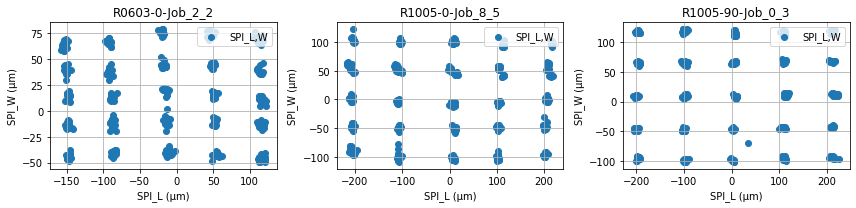

In [17]:
#### visualize (x, y)

xavg = 'SPI_L'
yavg = 'SPI_W'

# temp#_df: contains SPI_X_AVG and SPI_Y_AVG
temp1_df = temp1[[xavg, yavg]]
temp2_df = temp2[[xavg, yavg]]
temp3_df = temp3[[xavg, yavg]]

# visualize X, Y
fig = plt.figure(figsize=(12,3), facecolor='white')
for idx, group in enumerate([temp1, temp2, temp3]):
    # show average SPI X/Y
    x_group = group[xavg]
    y_group = group[yavg]
    ax = fig.add_subplot(1,3,idx+1)
    ax.scatter(x_group, y_group, label='SPI_L,W')
    ax.set_xlabel(f'{xavg} (\u03BCm)')
    ax.set_ylabel(f'{yavg} (\u03BCm)')
    ax.set_title(missing_chip[idx])
    ax.grid()
    ax.legend(loc='upper right')
    
    ''' show for each SPI_L1/W1, SPI_L2/W2
    x_group = group[x1]
    y_group = group[y1]
    ax = fig.add_subplot(2,3,idx+1)
    ax.scatter(x_group, y_group)
    ax.set_xlabel(x1)
    ax.set_ylabel(y1)
    ax.set_title(name)
    
    x_group = group[x2]
    y_group = group[y2]
    ax = fig.add_subplot(2,3,idx+4)
    ax.scatter(x_group, y_group)
    ax.set_xlabel(x2)
    ax.set_ylabel(y2)
    ax.set_title(name)
    '''
fig.tight_layout()
# plt.show()



R0603-0-Job_2_2: centroid 3 (Count: 14)
R1005-0-Job_8_5: centroid 2 (Count: 14)
R1005-90-Job_0_3: centroid 21 (Count: 14)


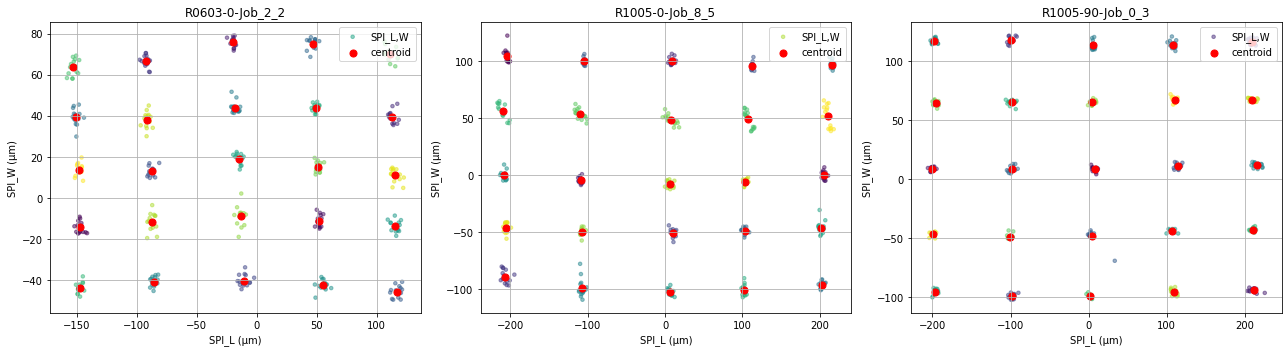

In [18]:
# clustering

from collections import defaultdict

def list_duplicates(seq):
    tally = defaultdict(list)
    for i,item in enumerate(seq):
        tally[item].append(i)
    return ((key,locs) for key,locs in tally.items() if len(locs)>1)

# 1. scikit learn - Kmeans
from sklearn.cluster import KMeans
missing_sample = dict()

fig = plt.figure(figsize=(18,5), facecolor='white')
temp_dfs = [temp1_df,temp2_df,temp3_df]
for temp_idx, temp_df in enumerate(temp_dfs):
    missing_sample[temp_idx] = []
    kmeans = KMeans(n_clusters=25).fit(temp_df)
    centroids = kmeans.cluster_centers_
    for dup in sorted(list_duplicates(kmeans.labels_)):
        if len(temp_df.iloc[dup[1],:]) < 15:
            missing_sample[temp_idx] = (dup[0], dup[1])
            chip_orient_job = missing_chip[temp_idx]
            print(f'{chip_orient_job}: centroid {dup[0]} (Count: {len(temp_df.iloc[dup[1],:])})')#' \n {temp_df.iloc[dup[1],:]} \n') # lists corresponding row indices for each centroid
        else:
            continue
    ax = fig.add_subplot(1,3,temp_idx+1)
    ax.scatter(temp_df[xavg], temp_df[yavg], c=kmeans.labels_.astype(float), marker='.',s=50, alpha=0.5, label='SPI_L,W')
    ax.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50, label='centroid')
    ax.set_xlabel(f'{xavg} (\u03BCm)')
    ax.set_ylabel(f'{yavg} (\u03BCm)')
    ax.legend(loc='upper right')
    ax.grid()
    ax.set_title(missing_chip[temp_idx])
fig.tight_layout()
# plt.show()
# fig.savefig('./stencils.png')

# 2. scipy - KMeans
# from scipy.cluster.vq import kmeans,vq
# from matplotlib import cm
# for temp_idx, temp_df in enumerate([temp1_df,temp2_df,temp3_df]):
#     centroids, _ = kmeans(temp_df, k_or_guess=25, thresh=1e-7)
#     plt.scatter(temp_df[xavg], temp_df[yavg], cmap=plt.get_cmap('jet'), s=50, alpha=0.5) # c=kmeans.labels_.astype(float),
#     plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
#     # plt.show()v

#     idx, _ = vq(temp1_df, centroids)
#     # print(idx) # idx = lists the centroid numbers for each row (of SPI)
#     for dup in sorted(list_duplicates(idx)):
#         if len(temp_df.iloc[dup[1],:]) < 15:
#             chip_orient_job = missing_chip[temp_idx]
#             print(f'{chip_orient_job}: centroid {dup[0]} (Count: {len(temp_df.iloc[dup[1],:])}) \
#                     \n {temp_df.iloc[dup[1],:]} \n') # lists corresponding row indices for each centroid

# from scipy.spatial import distance
# distance.euclidean(centroids, temp1_df)



In [19]:


# check: (parttype, orient, job) sample
print('====Sample====')
print(missing_chip[0],':')
print(temps[0].head(1))

print()
# check centroid values
# missing sample contains (centroid number, index in temp_dfs[i] for the centroid)
# temp_dfs contains dataframe corresponding to the chosen indices (for the centroids)
print('====Centroids====')
for i, (k, v) in enumerate(missing_sample.items()):
    print(f'{missing_chip[k]}:\n(index: {v}), \n(df: {temp_dfs[i].iloc[v[1],:].head(1)})')



====Sample====
R0603-0-Job_2_2 :
        CRD PartType  Orient.     X     Y  SPI_VOLUME1  SPI_VOLUME2  SPI_X1  \
48374  C376    R0603        0  93.0  40.5      86.3048      88.1976   -24.4   

       SPI_Y1  SPI_X2  SPI_Y2  SPI_L1  SPI_W1  SPI_L2  SPI_W2  SPI_L  SPI_W  \
48374    22.6    -9.3    18.0   -24.4    22.6    -9.3    18.0 -16.85   20.3   

           PRE_X      PRE_Y  PRE_A      PRE_L      PRE_W     POST_X  \
48374 -82.308685 -27.567791 -2.289 -82.308685 -27.567791 -27.305178   

          POST_Y  POST_A     POST_L     POST_W      Job  Chip_L  Chip_W  \
48374 -11.435584     0.0 -27.305178 -11.435584  Job_2_2   600.0   300.0   

           SPI_R      PRE_R    POST_R  SPI_VOLUME_MEAN  SPI_VOLUME_DIFF  
48374  26.382049  86.802665  29.60313          87.2512          -1.8928  

====Centroids====
R0603-0-Job_2_2:
(index: (3, [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])), 
(df:        SPI_L  SPI_W
48390  117.3  36.05)
R1005-0-Job_8_5:
(index: (2, [106, 107, 108, 109, 11

In [20]:
# imputation: KNN Imputer(2 neighbors)
from sklearn.impute import KNNImputer
import random

imputer = KNNImputer(n_neighbors=2, weights="uniform")
df_temp_save = df.copy()
# df_temp_save = df.copy().drop(columns=['SPI_VOLUME1', 'SPI_VOLUME2', 'SPI_R','PRE_R','POST_R','SPI_VOLUME_DIFF'])
for i in range(len(missing_sample)):
    # add a nan row, impute NaN, add to original by index, reset index
    # missing samples = dict with key = missing chip/orient/job, value = tuple (centroid, rows that correspond to that centroid containing missing row)
    tmp = temps[i].iloc[missing_sample[i][1],:].append(pd.Series(dtype=float), ignore_index=True)
    
    # columns to impute: float type
    cols_to_impute = ['X','Y',                       
                      'SPI_VOLUME1','SPI_VOLUME2',                       
                      'SPI_X1','SPI_Y1','SPI_X2','SPI_Y2',                       
                      'SPI_L1','SPI_W1','SPI_L2','SPI_W2',                       
                      'SPI_L','SPI_W', 
                      # 'SPI_R', \ # compute based on imputed SPI_L, SPI_W
                      'PRE_X','PRE_Y','PRE_A',\
                      'PRE_L','PRE_W', \
                      # 'PRE_R', \ # compute based on imputed PRE_L, PRE_W
                      'POST_X','POST_Y','POST_A',\
                      'POST_L','POST_W', \
                      # 'POST_R', \ # compute based on imputed POST_L, POST_W
                      'SPI_VOLUME_MEAN', 'SPI_VOLUME_DIFF', \
                      'Orient.']
    # drop CRD and PartType for imputation
    tmp = tmp[cols_to_impute]

    # perform imputation
    transformed = pd.DataFrame(imputer.fit_transform(tmp), columns=cols_to_impute).round(3)
    imputed = transformed.iloc[len(transformed)-1, :]
    
    centroid_index_start = temp_dfs[i].iloc[missing_sample[i][1],:].index[0]
    centroid_index_end = temp_dfs[i].iloc[missing_sample[i][1],:].index[-1]
    print('size changed: from',len(temp_dfs[i].iloc[missing_sample[i][1],:]),           'to', len(transformed), '/ indices corresp. to each centroid (from orig df): from',centroid_index_start,           'to', centroid_index_end)

    job,parttype,chipl,chipw,orient = df_temp_save.iloc[centroid_index_end, :][['Job','PartType','Chip_L','Chip_W','Orient.']]
    for col in list(df_temp_save.columns):
        if col not in cols_to_impute:
            # append random value to these columns
            if col == 'Job':
                imputed[col] = job
            elif col == 'PartType':
                imputed[col] = parttype
            elif col == 'Chip_L':
                imputed[col] = chipl
            elif col == 'Chip_W':
                imputed[col] = chipw
            elif col == 'Orient.':
                imputed[col] = orient
            elif col == 'CRD':
                imputed[col] = missing_crd[i]
            elif col == 'SPI_R':
                imputed[col] = np.linalg.norm((imputed['SPI_L'], imputed['SPI_W']))
            elif col == 'PRE_R':
                imputed[col] = np.linalg.norm((imputed['PRE_L'], imputed['PRE_W']))
            elif col == 'POST_R':
                imputed[col] = np.linalg.norm((imputed['POST_L'], imputed['POST_W']))
            elif col == 'SqueegeeCd':
                imputed[col] = random.choice(['R1','F1'])
            else:
                print('adding NaN for:',col)
                imputed[col] = np.nan
    assert len(imputed.index) == len(list(df_temp_save.columns))
#     print(imputed)
    df_temp_save = df_temp_save.append(imputed, ignore_index=True)
    
# scan for missing (parttype, orientation, job): 
# >> if none printed, then none missing! 
# >> all 15 reps, 25 stencil jobs, 81 chip jobs present
dfgroups = df_temp_save.groupby(['PartType','Orient.','Job'])
reps = 3*5     # chip offset
stencils = 5*5 # solder offset
t = tqdm(dfgroups)
for idx, (name, group) in enumerate(t):
    t.set_description(f'Checking: {name}')
    chiptype, orient, jobtype = name
    # 중복되는 job에 대해 15개 안되면 프린트
    jobcount = dict()
    for index, row in group.iterrows():
        job = row['Job']
        try:
            jobcount[job] += 1
        except:
            jobcount[job] = 1
    for key, values in jobcount.items():
        if values < (stencils * reps):
            print(chiptype, f'/ {orient} deg /', jobtype, ':', jobcount[key])



size changed: from 14 to 15 / indices corresp. to each centroid (from orig df): from 48390 to 48403
size changed: from 14 to 15 / indices corresp. to each centroid (from orig df): from 175229 to 175242
size changed: from 14 to 15 / indices corresp. to each centroid (from orig df): from 10635 to 10648


Checking: ('R1005', 90.0, 'Job_8_8'): 100%|██████████| 486/486 [00:11<00:00, 42.85it/s]


In [21]:


# check imputation result 

new_temp1 = df_temp_save.loc[(df_temp_save['PartType']=='R0603') & (df_temp_save['Orient.']==0) & (df_temp_save['Job']=='Job_2_2')]
new_temp2 = df_temp_save.loc[(df_temp_save['PartType']=='R1005') & (df_temp_save['Orient.']==0) & (df_temp_save['Job']=='Job_8_5')]
new_temp3 = df_temp_save.loc[(df_temp_save['PartType']=='R1005') & (df_temp_save['Orient.']==90) & (df_temp_save['Job']=='Job_0_3')]

[len(temp) for temp in [new_temp1, new_temp2, new_temp3]]
print('newly created rows for', missing_crd.values(),':')
new_temp1.loc[new_temp1['CRD']==missing_crd[0]]
new_temp2.loc[new_temp2['CRD']==missing_crd[1]]
new_temp3.loc[new_temp3['CRD']==missing_crd[2]]



newly created rows for dict_values(['C395', 'D492', 'D143']) :


,CRD,PartType,Orient.,X,Y,SPI_VOLUME1,SPI_VOLUME2,SPI_X1,SPI_Y1,SPI_X2,SPI_Y2,SPI_L1,SPI_W1,SPI_L2,SPI_W2,SPI_L,SPI_W,PRE_X,PRE_Y,PRE_A,PRE_L,PRE_W,POST_X,POST_Y,POST_A,POST_L,POST_W,Job,Chip_L,Chip_W,SPI_R,PRE_R,POST_R,SPI_VOLUME_MEAN,SPI_VOLUME_DIFF
182249,D143,R1005,90.0,119.04,88.66,95.98,93.458,95.3,104.136,95.493,114.243,104.136,-95.3,114.243,-95.493,109.189,-95.396,39.61,-196.183,0.133,-196.183,-39.61,-10.676,-28.23,2.49,-28.23,10.676,Job_0_3,1000.0,500.0,144.991843,200.141754,30.181284,94.719,2.522


In [24]:


df_imputed = df_temp_save.drop(columns=['SPI_X1','SPI_Y1','SPI_X2','SPI_Y2','SPI_L1','SPI_W1','SPI_L2','SPI_W2'])
df_imputed.to_csv('./datasets/imputed_data.csv')
df_imputed.head()



,CRD,PartType,Orient.,X,Y,SPI_VOLUME1,SPI_VOLUME2,SPI_L,SPI_W,PRE_X,PRE_Y,PRE_A,PRE_L,PRE_W,POST_X,POST_Y,POST_A,POST_L,POST_W,Job,Chip_L,Chip_W,SPI_R,PRE_R,POST_R,SPI_VOLUME_MEAN,SPI_VOLUME_DIFF
0,B1,R0402,90.0,31.26,100.11,81.7355,75.6950,61.90,52.0,-19.887293,-1.840963,-1.877,-1.840963,19.887293,-7.440417,28.108231,1.613,28.108231,7.440417,CENTER,400.0,200.0,80.843120,19.972320,29.076321,78.71525,6.0405
1,B2,R0402,90.0,31.83,100.11,83.1555,71.5083,63.70,47.0,-26.766272,6.898049,-1.449,6.898049,26.766272,5.487133,22.242701,0.000,22.242701,-5.487133,CENTER,400.0,200.0,79.162428,27.640847,22.909526,77.33190,11.6472
2,B3,R0402,90.0,32.40,100.11,87.0870,67.2606,72.35,41.6,-32.058273,8.125244,-3.278,8.125244,32.058273,-19.644203,12.971593,1.552,12.971593,19.644203,CENTER,400.0,200.0,83.457070,33.071929,23.540538,77.17380,19.8264
3,B4,R0402,90.0,32.97,100.11,80.0433,75.8866,63.10,50.6,-23.437572,-6.195457,-3.337,-6.195457,23.437572,-22.517658,26.396389,0.000,26.396389,22.517658,CENTER,400.0,200.0,80.882446,24.242596,34.696027,77.96495,4.1567
4,B5,R0402,90.0,33.54,100.11,76.7088,74.0452,69.45,50.0,-5.187286,7.085744,-3.408,7.085744,5.187286,-21.413681,29.193306,3.611,29.193306,21.413681,CENTER,400.0,200.0,85.576296,8.781555,36.204901,75.37700,2.6636


## 2. Clutering by SPI offset percentages


### clustering by SPI offset percentages (L, W)

>> **PartType**: 0402: width 200 um, length 400 um | 0603: width 300 um, length 600 um | 1005: width 500 um, length 1000 um

>> **CRD**: B: 0402, C: 0603, D: 1005

In [26]:
import os
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys
import warnings
warnings.filterwarnings("ignore")

import time
from sklearn.cluster import KMeans
import matplotlib.cm as cm

np.random.seed(42)

dir_path = pathlib.Path().absolute()
file = './datasets/imputed_data.csv'
data_path = os.path.join(dir_path, file)
print('MOM4 data path:', data_path)

df = pd.read_csv(data_path, index_col=False).drop(['Unnamed: 0'], axis=1)
df.reset_index(drop=True, inplace=True)
assert df.isnull().sum().sum() == 0

print('total (after imputation):',len(df))
df.head()

MOM4 data path: /home/user/Documents/kohyoung/kybayesopt_v2/./datasets/imputed_data.csv
total (after imputation): 182250


,CRD,PartType,Orient.,X,Y,SPI_VOLUME1,SPI_VOLUME2,SPI_L,SPI_W,PRE_X,PRE_Y,PRE_A,PRE_L,PRE_W,POST_X,POST_Y,POST_A,POST_L,POST_W,Job,Chip_L,Chip_W,SPI_R,PRE_R,POST_R,SPI_VOLUME_MEAN,SPI_VOLUME_DIFF
0,B1,R0402,90.0,31.26,100.11,81.7355,75.6950,61.90,52.0,-19.887293,-1.840963,-1.877,-1.840963,19.887293,-7.440417,28.108231,1.613,28.108231,7.440417,CENTER,400.0,200.0,80.843120,19.972320,29.076321,78.71525,6.0405
1,B2,R0402,90.0,31.83,100.11,83.1555,71.5083,63.70,47.0,-26.766272,6.898049,-1.449,6.898049,26.766272,5.487133,22.242701,0.000,22.242701,-5.487133,CENTER,400.0,200.0,79.162428,27.640847,22.909526,77.33190,11.6472
2,B3,R0402,90.0,32.40,100.11,87.0870,67.2606,72.35,41.6,-32.058273,8.125244,-3.278,8.125244,32.058273,-19.644203,12.971593,1.552,12.971593,19.644203,CENTER,400.0,200.0,83.457070,33.071929,23.540538,77.17380,19.8264
3,B4,R0402,90.0,32.97,100.11,80.0433,75.8866,63.10,50.6,-23.437572,-6.195457,-3.337,-6.195457,23.437572,-22.517658,26.396389,0.000,26.396389,22.517658,CENTER,400.0,200.0,80.882446,24.242596,34.696027,77.96495,4.1567
4,B5,R0402,90.0,33.54,100.11,76.7088,74.0452,69.45,50.0,-5.187286,7.085744,-3.408,7.085744,5.187286,-21.413681,29.193306,3.611,29.193306,21.413681,CENTER,400.0,200.0,85.576296,8.781555,36.204901,75.37700,2.6636


100%|██████████| 486/486 [00:56<00:00,  8.55it/s]


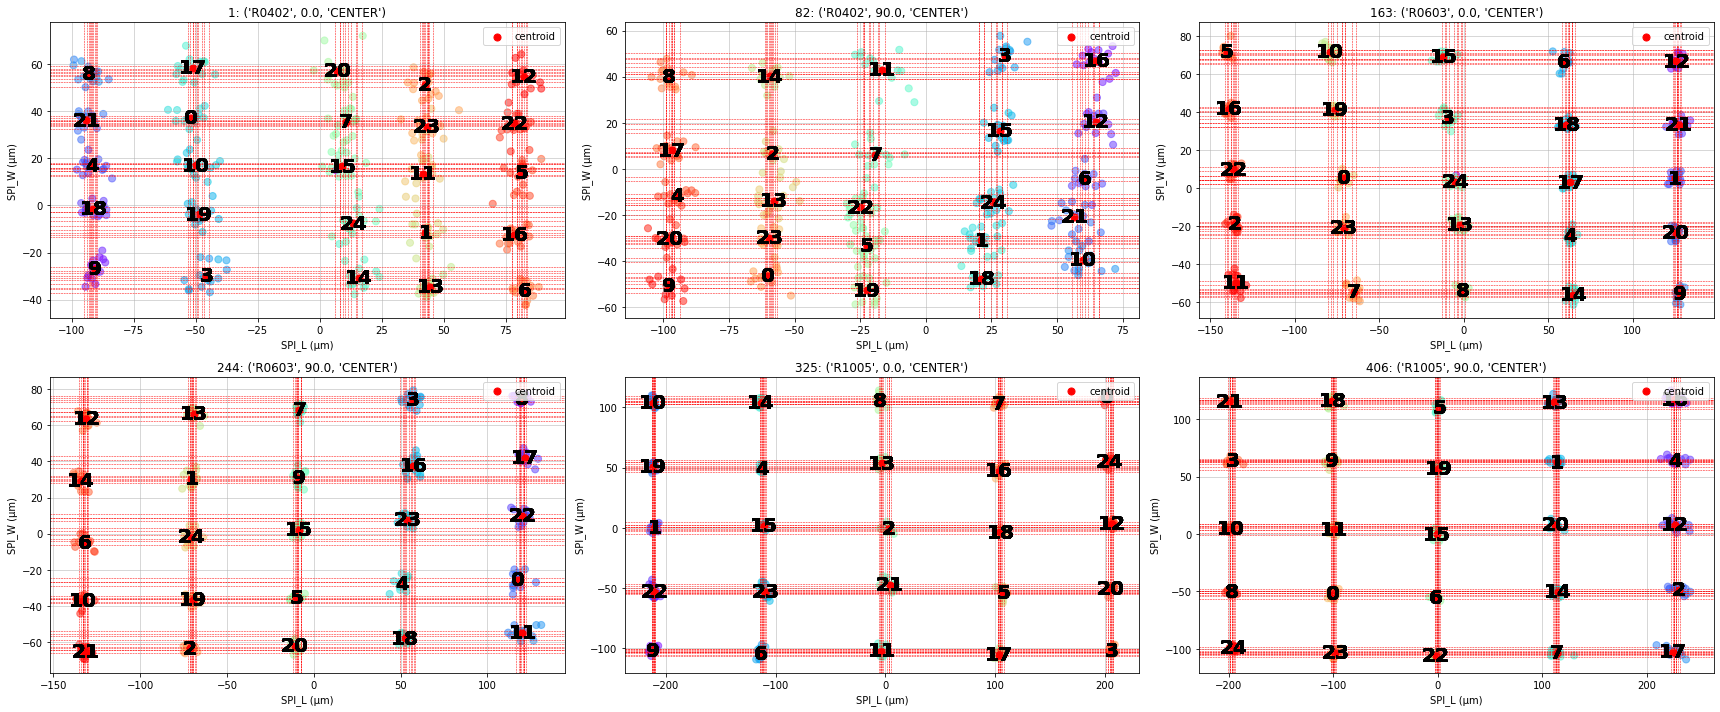

In [34]:
''' 
data: 3*2*(9*9)*15*(5*5) = 182250

	for each of 3 chips
		for each of 2 orientations
			for each of (9*9) chip placement offset conditions (jobs)
				for each of (5*5) spi conditions
					repeat for 15 reps
'''


dfgroups = df.groupby(['PartType','Orient.', 'Job'])
num_figs_to_visualize = 3 # total: dfgroups.ngroups (= 3*2*81 = 486)
fig = plt.figure(figsize=(num_figs_to_visualize*8, 5*2))
plot_subplot_idx = 1

num_repetitions = 15
visualize = True
spiws = []
spils = []

try:
    df.insert(9, 'spi_w_percentage', 0)
    df.insert(9, 'spi_l_percentage', 0)
except:
    df['spi_w_percentage'] = 0
    df['spi_l_percentage'] = 0

t = tqdm(enumerate(dfgroups), total=len(dfgroups))
for group_idx, (name, group) in t:
    # print(name)
    for row_idx, row in group.iterrows():
        # exception case: 'CENTER '
        if row['Job'] == 'CENTER ': row['Job'] = 'CENTER'
    if name[2] == 'CENTER ': name = (name[0], name[1], 'CENTER')
 
    assert len(group) == 375
    clf = KMeans(n_clusters=25).fit(group[['SPI_L','SPI_W']]) 
    centroids = clf.cluster_centers_
    labels = clf.labels_
    # labels = KMeans(n_clusters=25).fit_predict(group[['SPI_L','SPI_W']]) # worse center estimation results
    assert len(labels) == 375
    group['labels'] = labels.astype(int)
    
    df.loc[group.index, 'labels'] = labels.astype(int)

    # sort by cluster l, w
    group_sortedby_spil = group.sort_values(by=['SPI_L'], ascending=True)
    unique_labels = sorted(set(list(group_sortedby_spil['labels'])), key=list(group_sortedby_spil['labels']).index)
    # split into 5 blocks aligned in SPI L (each block contains a vertical five centroid groups)
    ordered_unique_labels = np.array_split(unique_labels, 5)

    # organize into 75 SPI L and 15*[-20, -10, 0, 10, 20] SPI W to add columns to df by index
    group_indices = []
    for label_list in ordered_unique_labels:
        store_midindex_list = dict() # stores midindex of the group and spi w
        store_groups = dict()        # stores group indexed by midindex
        for i, label in enumerate(label_list):
            group_by_label = group_sortedby_spil[group_sortedby_spil['labels']==label]
            indices = group_by_label.index
            midindex = indices[int(len(indices)/2)]

            store_midindex_list[i] = (midindex, group_by_label.loc[midindex, 'SPI_W'])
            store_groups[midindex] = group_by_label

        # sort midindex list by spi w
        store_midindex_list = sorted(list(store_midindex_list.values()), key=lambda x:x[1])

        new_sorted_group_list = []
        for j, (midindex, _) in enumerate(store_midindex_list):
            new_sorted_group_list.append(store_groups[midindex])

            group_indices.append(store_groups[midindex].index)
    assert len(group_indices) == 25

    # add SPI L, W percentages to dataframe
    idx_to_percentage = {0: -20, 1: -10, 2: 0, 3: 10, 4: 20}
    spil_idx_key = 0
    for i, index_list in enumerate(group_indices):
        # key for spi w
        spiw_idx_key = i % 5
        spiw_percent = idx_to_percentage[spiw_idx_key]
        
        df.loc[index_list, 'spi_w_percentage'] = spiw_percent
        if i != 0 and i % 5 == 0:
            spil_idx_key += 1
        spil_percent = idx_to_percentage[spil_idx_key]
        df.loc[index_list, 'spi_l_percentage'] = spil_percent
    
    if visualize:
        if plot_subplot_idx == num_figs_to_visualize*2+1:
            continue

        if name == ('R0402', 90.0, 'CENTER') or name == ('R0603', 90.0, 'CENTER') or name == ('R1005', 90.0, 'CENTER') or \
            name == ('R0402', 0.0, 'CENTER') or name == ('R0603', 0.0, 'CENTER') or name == ('R1005', 0.0, 'CENTER'):
        # if True: # apply condition if visualizing only specific parts
            ax = fig.add_subplot(2, num_figs_to_visualize, plot_subplot_idx)

            colors = cm.rainbow(np.linspace(0, 1, len(labels)))
            ax.scatter(group['SPI_L'], group['SPI_W'], c=colors, s=50, alpha=0.5, label='_nolegend_')
            ax.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50, label='centroid')

            # annotate label
            for i, label in enumerate(group['labels']):
                ax.annotate(label, (centroids[label,0], centroids[label,1]),
                        horizontalalignment='center',
                        verticalalignment='center',
                        size=20, weight='bold', color='black') # backgroundcolor='white', color=colors[i])

            # draw bounding lines for centroids
            for ctrd in centroids:
                ax.axhline(y=ctrd[1]-1, color='r', linestyle='--', linewidth=0.5)
                ax.axhline(y=ctrd[1]+1, color='r', linestyle='--', linewidth=0.5)

                ax.axvline(x=ctrd[0]-1, color='r', linestyle='--', linewidth=0.5)
                ax.axvline(x=ctrd[0]+1, color='r', linestyle='--', linewidth=0.5)

            ax.set_xlabel(f'SPI_L (\u03BCm)')
            ax.set_ylabel(f'SPI_W (\u03BCm)')
            ax.legend(loc='upper right')
            ax.grid(linewidth=0.5)
            # ax.set_xlim([-200, 200])
            # ax.set_ylim([-200, 200])
            ax.set_title(f'{group_idx+1}: {name}')
            
            plot_subplot_idx += 1

fig.tight_layout()
plt.savefig('datasets/spi_lw_labeled.png', facecolor='w', bbox_inches='tight')
plt.show()


In [35]:

pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows', None)
df.head(5)

,CRD,PartType,Orient.,X,Y,SPI_VOLUME1,SPI_VOLUME2,SPI_L,SPI_W,spi_l_percentage,spi_w_percentage,PRE_X,PRE_Y,SPI_W_ERROR,SPI_L_ERROR,PRE_A,PRE_L,PRE_W,POST_X,POST_Y,POST_A,POST_L,POST_W,Job,Chip_L,Chip_W,SPI_R,PRE_R,POST_R,SPI_VOLUME_MEAN,SPI_VOLUME_DIFF,labels
0,B1,R0402,90.0,31.26,100.11,81.7355,75.6950,61.90,52.0,20,20,-19.887293,-1.840963,0,0,-1.877,-1.840963,19.887293,-7.440417,28.108231,1.613,28.108231,7.440417,CENTER,400.0,200.0,80.843120,19.972320,29.076321,78.71525,6.0405,16.0
1,B2,R0402,90.0,31.83,100.11,83.1555,71.5083,63.70,47.0,20,20,-26.766272,6.898049,0,0,-1.449,6.898049,26.766272,5.487133,22.242701,0.000,22.242701,-5.487133,CENTER,400.0,200.0,79.162428,27.640847,22.909526,77.33190,11.6472,16.0
2,B3,R0402,90.0,32.40,100.11,87.0870,67.2606,72.35,41.6,20,20,-32.058273,8.125244,0,0,-3.278,8.125244,32.058273,-19.644203,12.971593,1.552,12.971593,19.644203,CENTER,400.0,200.0,83.457070,33.071929,23.540538,77.17380,19.8264,16.0
3,B4,R0402,90.0,32.97,100.11,80.0433,75.8866,63.10,50.6,20,20,-23.437572,-6.195457,0,0,-3.337,-6.195457,23.437572,-22.517658,26.396389,0.000,26.396389,22.517658,CENTER,400.0,200.0,80.882446,24.242596,34.696027,77.96495,4.1567,16.0
4,B5,R0402,90.0,33.54,100.11,76.7088,74.0452,69.45,50.0,20,20,-5.187286,7.085744,0,0,-3.408,7.085744,5.187286,-21.413681,29.193306,3.611,29.193306,21.413681,CENTER,400.0,200.0,85.576296,8.781555,36.204901,75.37700,2.6636,16.0


### Chip placement (mounter) error

In [36]:

import os

import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys

import matplotlib.pylab as pl

# set data path
# dir_path = pathlib.Path().absolute()
# file = './datasets/spi_clustered.csv'
# data_path = os.path.join(dir_path, file)
# print('MOM4 data located at:', data_path)
# df = pd.read_csv(data_path, index_col=False).drop(['Unnamed: 0'], axis=1)
# df.reset_index(drop=True, inplace=True)
# assert df.isnull().sum().sum() == 0

pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows', None)
df['Orient.'] = df['Orient.'].apply(pd.to_numeric, errors='ignore').astype('int')
for col in ['X','Y','SPI_VOLUME1','SPI_VOLUME2','POST_R','POST_X','POST_Y','PRE_X','PRE_Y','PRE_R','SPI_L1','SPI_L2','SPI_R','SPI_W1','SPI_W2','SPI_X1','SPI_X2','SPI_Y1','SPI_Y2']:
    try: df.drop(columns=col, inplace=True)
    except: pass
df.sort_values(['CRD'], ascending=[True], inplace=True)
df.reset_index(inplace=True, drop=True)
df = df.reindex(columns=sorted(df.columns))
parttypes = df['PartType']
df.drop(columns=['PartType'], axis=1, inplace=True)
df.insert(1, 'PartType', parttypes)

# chip placement percentage column
l_list = np.arange(0,9,1)
w_list = np.arange(0,9,1)
job_list = [f'Job_{l}_{w}' for l in l_list for w in w_list]

w_list = [i for item in list(np.arange(-20,25,5)) for i in [item]]*9 # width percentage = y direction
l_list = [i for item in list(np.arange(-20,25,5)) for i in [item]*9] # length percentage = x direction
value_list = [(int(l),int(w)) for (l,w) in zip(l_list, w_list)]
job_idx_to_percentage = dict(zip(job_list, value_list)) # job to chip placement offset perentages

try:
    df.insert(12, 'PRE_W_calc', 0)
    df.insert(12, 'PRE_L_calc', 0)
except: pass
dfgroups = df.groupby(['PartType', 'Orient.'])
curr_job = ''
t = tqdm(enumerate(dfgroups), total=len(dfgroups))
for idx, (name, group) in t:
    t.set_description(name[0] + '__' + str(name[1]))
    for row_idx, row in group.iterrows():
        crd = row['CRD']
        chip_l = row['Chip_L']
        chip_w = row['Chip_W']
        job = row['Job']
        if job == 'CENTER' or job == 'CENTER ': job = 'Job_4_4'
        
        # set x,y offset percentages by job type (or crd)
        l, w = job_idx_to_percentage[job]
        df.at[row_idx, 'PRE_L_calc'] = l/100 * chip_l
        df.at[row_idx, 'PRE_W_calc'] = w/100 * chip_w

try: 
    df.insert(18, 'PRE_L_ERROR', abs(df['PRE_L']-df['PRE_L_calc']))
    df.insert(18, 'PRE_W_ERROR', abs(df['PRE_W']-df['PRE_W_calc']))
except: pass
df.head()

dfgroups = df.groupby(['PartType', 'Orient.'])
t = tqdm(enumerate(dfgroups), total=len(dfgroups))
for idx, (name, group) in t:
    print(name, group[['PRE_W_ERROR','PRE_L_ERROR']].describe())

100%|██████████| 6/6 [00:00<00:00, 92.32it/s]

('R0402', 0)         PRE_W_ERROR   PRE_L_ERROR
count  30375.000000  30375.000000
mean      10.719577     10.613475
std        9.320190      8.903261
min        0.000795      0.000170
25%        4.284933      3.726062
50%        8.700418      8.310802
75%       14.467230     15.310414
max       98.841072    142.200329
('R0402', 90)         PRE_W_ERROR   PRE_L_ERROR
count  30375.000000  30375.000000
mean      17.998022     10.610694
std        8.572417      8.870104
min        0.006622      0.000284
25%       12.113063      3.929094
50%       17.915028      8.402363
75%       23.468857     15.015974
max       92.678841     81.332706
('R0603', 0)         PRE_W_ERROR   PRE_L_ERROR
count  30375.000000  30375.000000
mean      10.146392     13.809804
std        8.212364      7.209009
min        0.000237      0.001532
25%        3.767009      8.431794
50%        8.155991     13.627928
75%       14.462671     18.737322
max      110.771622     43.257431
('R0603', 90)         PRE_W_ERROR   PRE_L_

### spi printer error

In [37]:
# dir_path = pathlib.Path().absolute()
# file = './datasets/spi_clustered.csv'
# data_path = os.path.join(dir_path, file)
# print('MOM4 data located at:', data_path)
# df = pd.read_csv(data_path, index_col=False).drop(['Unnamed: 0'], axis=1)

try:
    df.insert(11, 'SPI_L_ERROR', 0)
    df.insert(11, 'SPI_W_ERROR', 0)
except:
    df['SPI_L_ERROR'] = 0
    df['SPI_W_ERROR'] = 0

num_print = 0
if num_print > 0: print('\t[CALCULATED]\t[ACTUAL]\t[ERROR]')

print()
for i, row in tqdm(df.iterrows(), total=len(df)):
    calc_spi_l = row['Chip_L'] * row['spi_l_percentage']/100
    calc_spi_w = row['Chip_W'] * row['spi_w_percentage']/100

    actual_spi_l = row['SPI_L']
    actual_spi_w = row['SPI_W']

    error_spi_l = abs(calc_spi_l - actual_spi_l)
    error_spi_w = abs(calc_spi_w - actual_spi_w)
    if i < num_print:
        print(f'\t{calc_spi_l}, {calc_spi_w} | {actual_spi_l:.3f}, {actual_spi_w:.3f} | {error_spi_l:.3f}, {error_spi_w:.3f}')

    df.loc[i, 'SPI_L_ERROR'] = error_spi_l
    df.loc[i, 'SPI_W_ERROR'] = error_spi_w

print('\n')
dfgroups = df.groupby(['PartType', 'Orient.'])
t = tqdm(enumerate(dfgroups), total=len(dfgroups))
for idx, (name, group) in t:
    print(name, group[['SPI_W_ERROR','SPI_L_ERROR']].describe())

  0%|          | 10/182250 [00:00<30:42, 98.91it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 79.45it/s]

('R0402', 0)         SPI_W_ERROR   SPI_L_ERROR
count  30375.000000  30375.000000
mean      16.242951     10.819295
std       10.844870      7.902663
min        0.000000      0.000000
25%        7.400000      4.400000
50%       15.300000      9.500000
75%       23.400000     15.850000
max       67.800000     59.600000
('R0402', 90)         SPI_W_ERROR   SPI_L_ERROR
count  30375.000000  30375.000000
mean       9.146133     15.919044
std        6.662915     10.978635
min        0.000000      0.000000
25%        3.800000      7.150000
50%        7.950000     14.200000
75%       13.200000     22.700000
max       47.150000     67.200000
('R0603', 0)         SPI_W_ERROR   SPI_L_ERROR
count  30375.000000  30375.000000
mean      10.913811     11.527717
std        8.503518      8.400911
min        0.000000      0.000000
25%        4.450000      4.600000
50%        9.300000      9.800000
75%       15.550000     17.350000
max       63.000000     47.850000
('R0603', 90)         SPI_W_ERROR   SPI_L_

In [38]:
df.to_csv('./datasets/spi_clustered.csv')
df.head(10)

,CRD,PartType,Chip_L,Chip_W,Job,Orient.,POST_A,POST_L,POST_W,PRE_A,PRE_L,PRE_W,PRE_L_calc,PRE_W_calc,SPI_L,SPI_L_ERROR,SPI_VOLUME_DIFF,SPI_VOLUME_MEAN,PRE_W_ERROR,PRE_L_ERROR,SPI_W,SPI_W_ERROR,labels,spi_l_percentage,spi_w_percentage
0,B1,R0402,400.0,200.0,CENTER,90,1.613,28.108231,7.440417,-1.877,-1.840963,19.887293,0,0,61.90,18.10,6.0405,78.71525,19.887293,1.840963,52.00,12.00,16.0,20,20
1,B1,R0402,400.0,200.0,Job_4_5,90,3.408,20.938316,29.957253,1.613,6.678457,37.073589,0,10,92.25,12.25,21.7198,83.44790,27.073589,6.678457,23.15,16.85,9.0,20,20
2,B1,R0402,400.0,200.0,Job_3_8,90,-1.632,25.206312,56.721851,0.000,-18.385906,62.718262,-20,40,83.70,3.70,14.5403,84.84665,22.718262,1.614094,54.30,14.30,6.0,20,20
3,B1,R0402,400.0,200.0,Job_5_2,90,0.000,26.923147,15.511544,-3.337,27.223391,1.545374,20,-20,75.50,4.50,5.5369,78.57365,21.545374,7.223391,60.90,20.90,4.0,20,20
4,B1,R0402,400.0,200.0,Job_3_5,90,1.449,33.391376,21.369270,3.248,-27.810768,52.726315,-20,10,68.90,11.10,11.0323,88.74905,42.726315,7.810768,49.70,9.70,15.0,20,20
5,B1,R0402,400.0,200.0,Job_4_8,90,-3.611,45.608845,60.187107,1.632,11.587806,63.271469,0,40,84.35,4.35,5.8759,84.26505,23.271469,11.587806,47.05,7.05,10.0,20,20
6,B1,R0402,400.0,200.0,Job_6_7,90,1.552,25.155458,52.328278,0.000,43.588417,58.978840,40,30,67.35,12.65,21.3568,86.21030,28.978840,3.588417,46.35,6.35,16.0,20,20
7,B1,R0402,400.0,200.0,Job_1_8,90,-3.907,19.614975,29.141289,0.000,-53.517506,58.552654,-60,40,56.25,23.75,13.6228,95.13520,18.552654,6.482494,44.35,4.35,10.0,20,20
8,B1,R0402,400.0,200.0,Job_0_3,90,-20.157,-25.628412,-66.586098,-1.449,-73.016808,16.472124,-80,-10,64.70,15.30,7.3940,75.08630,26.472124,6.983192,61.85,21.85,12.0,20,20
9,B1,R0402,400.0,200.0,Job_8_5,90,3.278,29.751282,26.010839,1.632,103.501587,31.395697,80,10,33.55,46.45,3.9708,100.01570,21.395697,23.501587,22.95,2.95,7.0,20,10


In [ ]:
# def list_duplicates(seq):
# 	tally = defaultdict(list)
# 	for i, item in enumerate(seq):
# 		tally[item].append(i)
# 	return ((key, locs) for key, locs in tally.items() if len(locs) > 1)
